<a href="https://colab.research.google.com/github/Eric-zambom/Senac/blob/master/Deteccao_Covid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from glob import glob

from tensorflow import keras
from keras import layers
from keras.models import Sequential

In [27]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("plameneduardo/sarscov2-ctscan-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'sarscov2-ctscan-dataset' dataset.
Path to dataset files: /kaggle/input/sarscov2-ctscan-dataset


In [28]:
batch_size = 32
img_height = 250
img_width = 250

In [29]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2481 files belonging to 2 classes.
Using 1985 files for training.


In [30]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2481 files belonging to 2 classes.
Using 496 files for validation.


In [31]:
class_names = train_ds.class_names
print(class_names)

['COVID', 'non-COVID']


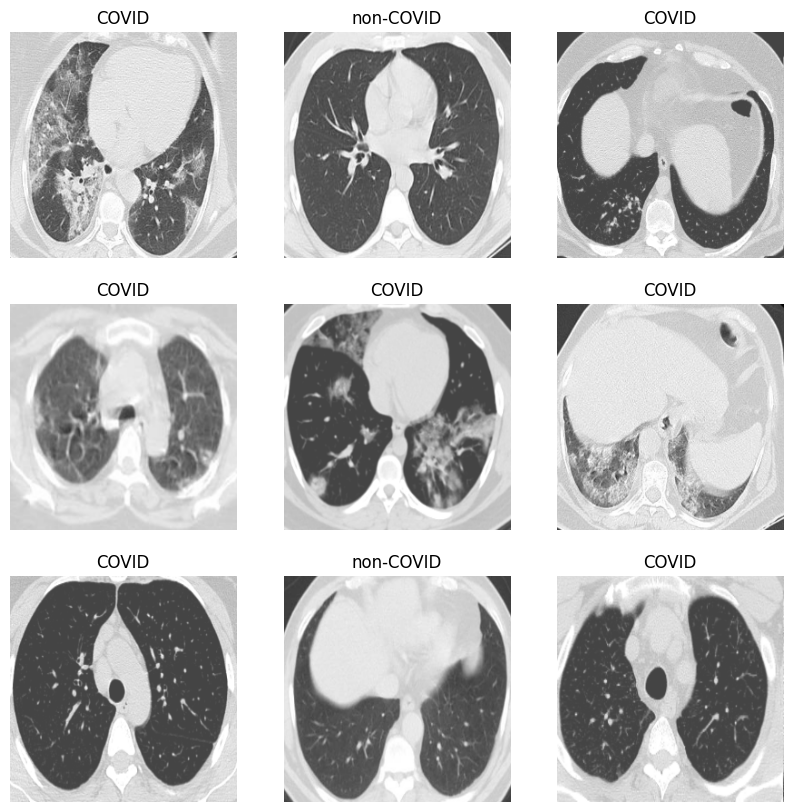

In [32]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [33]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 250, 250, 3)
(32,)


In [34]:
normalization_layer = layers.Rescaling(1./255)

In [35]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.22297812 1.0


In [36]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [37]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [38]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_4 (Rescaling)         │ (None, 250, 250, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 250, 250, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 125, 125, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 62, 62, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 31, 31, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 61504)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     7,872,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,896,482 (30.12 MB)

 Trainable params: 7,896,482 (30.12 MB)

 Non-trainable params: 0 (0.00 B)

In [39]:
epochs=50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 146s 2s/step - accuracy: 0.5540 - loss: 0.8237 - val_accuracy: 0.6431 - val_loss: 0.6650
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 208s 2s/step - accuracy: 0.6438 - loss: 0.6372 - val_accuracy: 0.7298 - val_loss: 0.5674
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 151s 2s/step - accuracy: 0.8240 - loss: 0.3834 - val_accuracy: 0.8327 - val_loss: 0.3766
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 150s 2s/step - accuracy: 0.9118 - loss: 0.2262 - val_accuracy: 0.8125 - val_loss: 0.4642
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 152s 2s/step - accuracy: 0.9317 - loss: 0.1672 - val_accuracy: 0.8810 - val_loss: 0.3198
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - accuracy: 0.9673 - loss: 0.0924 - val_accuracy: 0.8992 - val_loss: 0.3274
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 152s 2s/step - accuracy: 0.9640 - loss: 0.0968 - val_accuracy: 0.8730 - val_loss: 0.3639
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 202s 2s/step - accuracy: 0.9764 - loss: 0.0765 - val_accuracy: 0.8891 - v

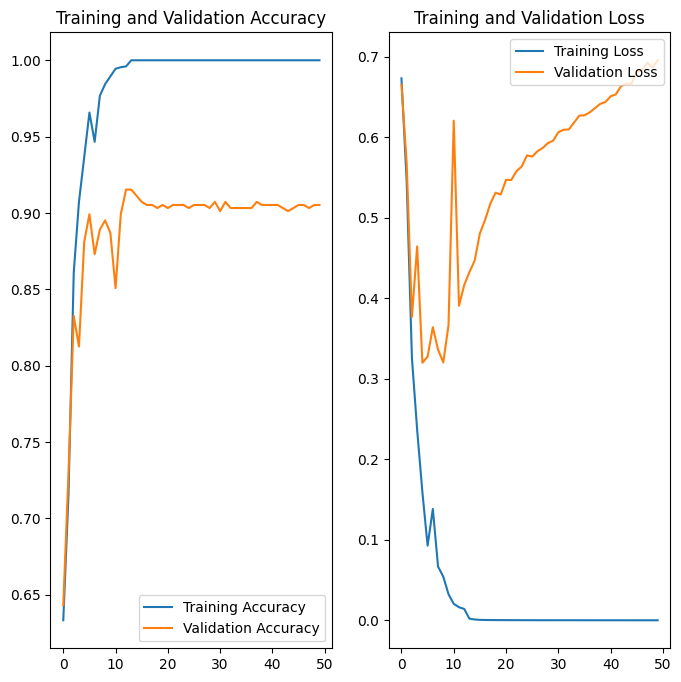

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [41]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

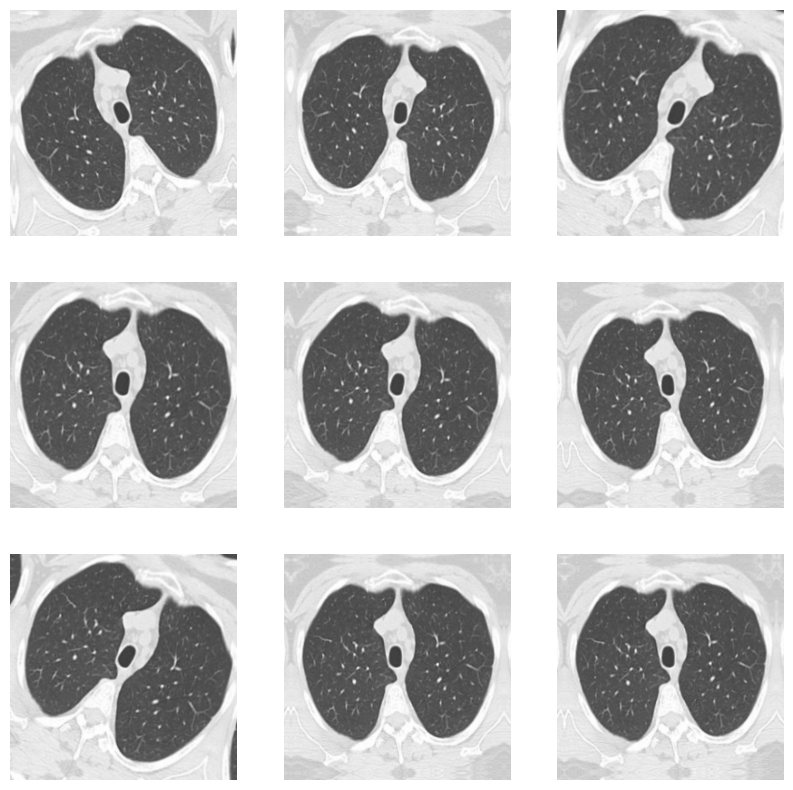

In [42]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [43]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [44]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [45]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_4 (Sequential)       │ (None, 250, 250, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_5 (Rescaling)         │ (None, 250, 250, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 250, 250, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 125, 125, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 62, 62, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 31, 31, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 31, 31, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 61504)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     7,872,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,896,482 (30.12 MB)

 Trainable params: 7,896,482 (30.12 MB)

 Non-trainable params: 0 (0.00 B)

In [46]:
epochs = 50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 176s 3s/step - accuracy: 0.5175 - loss: 1.0325 - val_accuracy: 0.7157 - val_loss: 0.5868
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 192s 3s/step - accuracy: 0.6548 - loss: 0.6204 - val_accuracy: 0.6714 - val_loss: 0.6351
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 172s 3s/step - accuracy: 0.7187 - loss: 0.5646 - val_accuracy: 0.7440 - val_loss: 0.5288
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 196s 3s/step - accuracy: 0.7395 - loss: 0.5292 - val_accuracy: 0.8226 - val_loss: 0.4096
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 208s 3s/step - accuracy: 0.7820 - loss: 0.4796 - val_accuracy: 0.5323 - val_loss: 0.9184
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 171s 3s/step - accuracy: 0.7411 - loss: 0.5405 - val_accuracy: 0.7319 - val_loss: 0.5140
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 202s 3s/step - accuracy: 0.7880 - loss: 0.4608 - val_accuracy: 0.7702 - val_loss: 0.4521
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 185s 3s/step - accuracy: 0.8215 - loss: 0.4056 - val_accuracy: 0.8649 - v

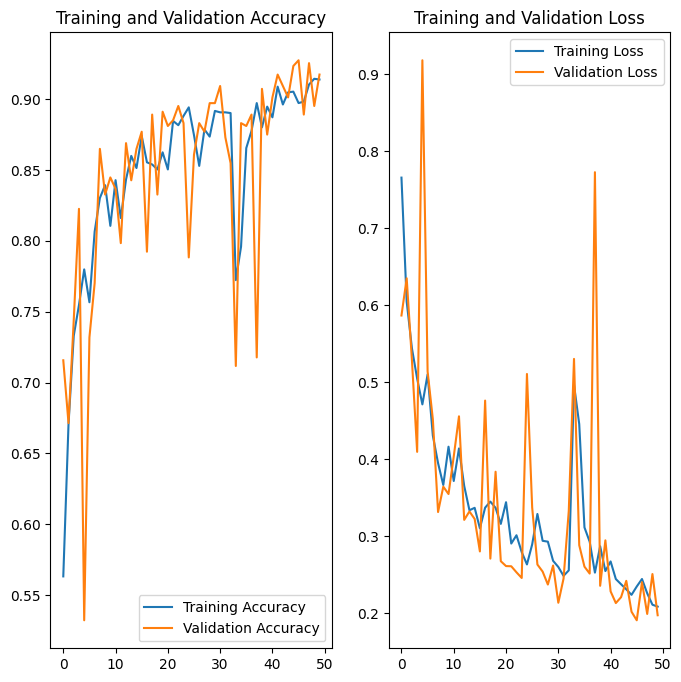

In [49]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [53]:
image_test_url = "/content/Covid (479).png"
image_test_path = tf.keras.utils.get_file('test_image', origin=image_test_url)

img = tf.keras.utils.load_img(
    image_test_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
This image most likely belongs to COVID with a 100.00 percent confidence.
